# Graph Convolutional Networks
## Node Classification Facebook Page-Page dataset
This dataset was introduced by Rozemberczki et al. in 2019. It was created using the Facebook Graph API in November 2017. In this dataset, each of the 22,470 nodes represents an official Facebook page. Pages are connected when there are mutual likes between them. Node features (128-dim vectors) are created from textual descriptions written by the owners of these pages. Our goal is to classify each node into one of four categories:

politicians
companies
television shows
governmental organizations.
The Facebook Page-Page dataset is similar to the previous one: it’s a social network with a node classification task. However, there are three major differences with Cora:

The number of nodes is much higher (2,708 versus 22,470) The dimensionality of the node features decreased dramatically (from 1,433 to 128) The goal is to classify each node into four categories instead of seven (which is easier since there are fewer options) The following figure is a visualization of the dataset using Gephi. First, nodes with few connections have been filtered out to improve performance. The size of the remaining nodes depends on their number of connections, and their color indicates the category they belong to. Finally, two layouts have been applied: Fruchterman-Reingold and ForceAtlas2.

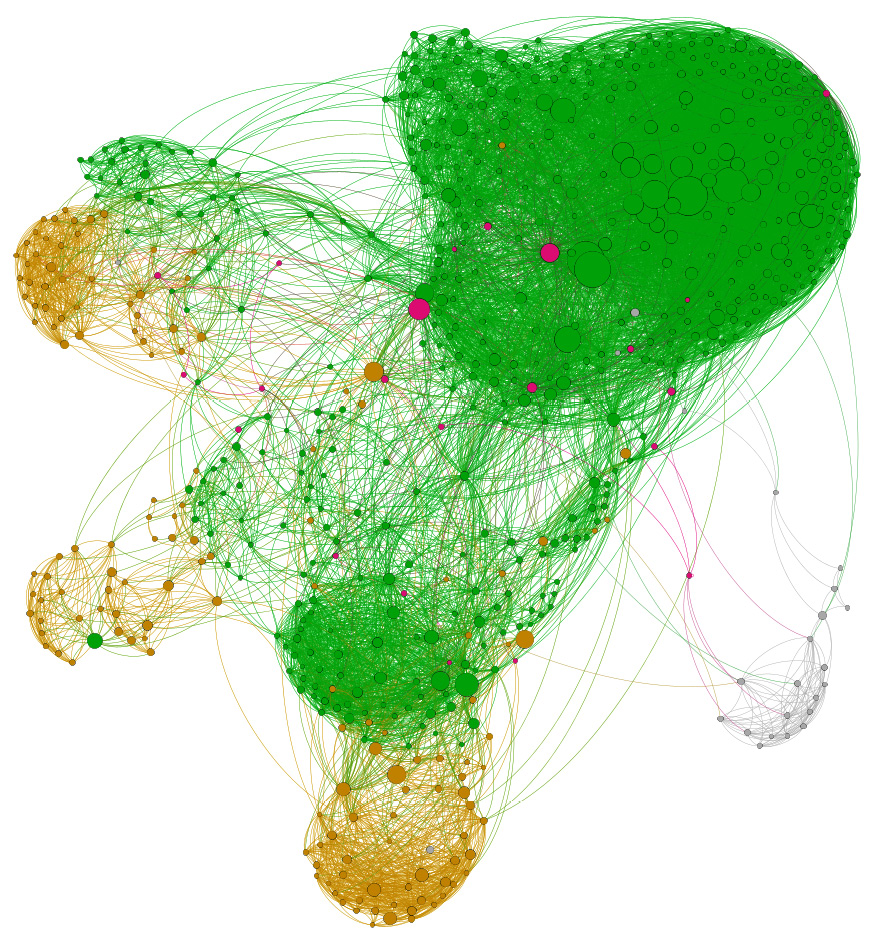

In [1]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 83.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 89.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.6/886.6 kB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [9]:
import torch
torch.manual_seed(1)
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import FacebookPagePage
from torch_geometric.utils import degree
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)

In [4]:
# Import dataset from PyTorch Geometric
dataset = FacebookPagePage(root=".")
data = dataset[0]

Processing...
Done!


In [5]:
# Create masks
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

In [10]:
# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

<BarContainer object of 233 artists>

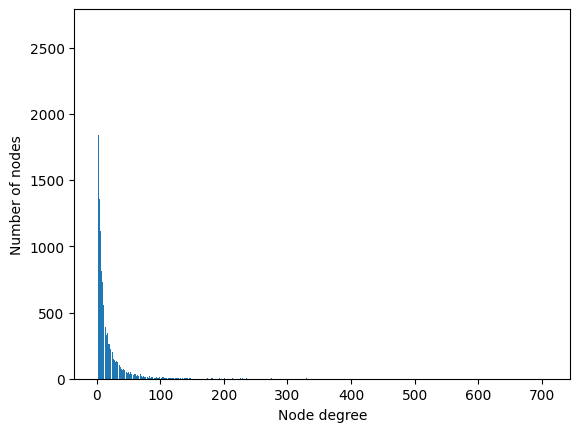

In [11]:
# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

In [20]:
# Build GCN
class GCN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.conv1 = GCNConv(dim_in, dim_h*3)
        self.conv2 = GCNConv(dim_h*3, dim_h*2)
        self.conv3 = GCNConv(dim_h*2, dim_h)
        self.conv4 = GCNConv(dim_h, dim_out)

def forward(self, x, edge_index):
        # Primera Convolución
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = F.dropout(h, p=0.4, training=self.training)

        # Segunda Convolución
        h = self.conv2(h, edge_index)
        h = F.dropout(h, p=0.4, training=self.training)

        # Tercera Convolución
        h = self.conv3(h, edge_index)
        h = F.dropout(h, p=0.4, training=self.training)

        # Cuarta Convoloución
        h = self.conv4(h, edge_index)


        return F.log_softmax(h, dim=1)
GCN.forward = forward

#Fit
def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss() #Categorical cross entrophy loss
    optimizer = torch.optim.Adam(self.parameters(), #
                                  lr=0.03,
                                  weight_decay=5e-4)
    self.train()
    for epoch in range(epochs+1):
        optimizer.zero_grad() #Inicializamos parametros en cero.
        out = self(data.x, data.edge_index) #CAlculo salidas del modelo
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1),
                      data.y[data.train_mask])
        loss.backward()#Propaga el error a través del modelo para calcular los gradientes.
        optimizer.step() #Actualizacion de pesos

        if(epoch % 20 == 0): #Cada 20 epocas nos imprima como va.
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                              data.y[data.val_mask])
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                  f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

GCN.fit = fit

#Test

@torch.no_grad()
def test(self, data):
    self.eval()
    out = self(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

GCN.test = test

In [21]:
# Train GCN
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)
gcn.fit(data, epochs=100)
acc = gcn.test(data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (conv1): GCNConv(128, 48)
  (conv2): GCNConv(48, 32)
  (conv3): GCNConv(32, 16)
  (conv4): GCNConv(16, 4)
)
Epoch   0 | Train Loss: 1.613 | Train Acc: 23.35% | Val Loss: 1.63 | Val Acc: 24.16%
Epoch  20 | Train Loss: 0.343 | Train Acc: 89.62% | Val Loss: 0.32 | Val Acc: 89.64%
Epoch  40 | Train Loss: 0.254 | Train Acc: 92.46% | Val Loss: 0.25 | Val Acc: 91.80%
Epoch  60 | Train Loss: 0.223 | Train Acc: 93.56% | Val Loss: 0.22 | Val Acc: 93.30%
Epoch  80 | Train Loss: 0.204 | Train Acc: 93.99% | Val Loss: 0.21 | Val Acc: 93.95%
Epoch 100 | Train Loss: 0.190 | Train Acc: 94.46% | Val Loss: 0.19 | Val Acc: 94.05%

GCN test accuracy: 94.29%



Resultados Profe

In [ ]:
# Train GCN
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)
gcn.fit(data, epochs=100)
acc = gcn.test(data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(128, 16)
  (gcn2): GCNConv(16, 4)
)
Epoch   0 | Train Loss: 1.463 | Train Acc: 20.72% | Val Loss: 1.45 | Val Acc: 20.71%
Epoch  20 | Train Loss: 0.443 | Train Acc: 84.64% | Val Loss: 0.43 | Val Acc: 85.29%
Epoch  40 | Train Loss: 0.323 | Train Acc: 89.59% | Val Loss: 0.31 | Val Acc: 90.20%
Epoch  60 | Train Loss: 0.278 | Train Acc: 91.34% | Val Loss: 0.27 | Val Acc: 91.55%
Epoch  80 | Train Loss: 0.254 | Train Acc: 92.28% | Val Loss: 0.26 | Val Acc: 92.75%
Epoch 100 | Train Loss: 0.238 | Train Acc: 92.82% | Val Loss: 0.25 | Val Acc: 92.75%

GCN test accuracy: 91.70%

